In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

2023-11-06 16:06:36.592858: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 16:06:36.628861: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 16:06:36.802841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 16:06:36.802887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 16:06:36.803854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [ ]:
if tf.test.is_gpu_available():
    print("GPU is available and TensorFlow is using it.")
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available; TensorFlow is running on CPU.")


# Load and prepare the data

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # reshape to 28x28x1
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [3]:
#take the dataset, shuffle it, and batch it to 256

BUFFER_SIZE = 60000
BATCH_SIZE = 256 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #now train dataset everytime we call it, it will give us another batch of 256 images

2023-11-06 16:10:44.871808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Create the models

In [9]:
def build_generator():
    model = tf.keras.Sequential()
    
    # take a random 100 dimensional noise vector and turns it into a 7x7x256 dimensional vector
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    
    # upsample to 7x7x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # upsample to 14x14x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # upsample to 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

generator = build_generator()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_12 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 7, 7, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_13 (Ba  (None, 7, 7, 128)        

(1, 28, 28, 1)


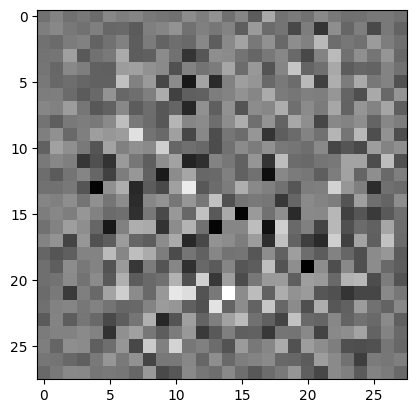

In [11]:
# predicting some random generated images and visualizing them 
noise = tf.random.normal([1, 100]) # tf.random.normal([1, 100]) creates a 1x100 dimensional vector of random numbers
generated_image = generator(noise, training=False) # generate an image from the noise vector
print(generated_image.shape) # print the shape of the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray') # plot the image # generated_image[0, :, :, 0] is the first image in the batch, the :, :, 0 is to remove the color dimension

In [12]:
def build_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])) # 28x28x1 -> 14x14x64
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) # 14x14x64 -> 7x7x128
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten()) # 7x7x128 -> 6272
    model.add(layers.Dense(1)) # 6272 -> 1
    
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [13]:
# predicting if the generated image is real or fake
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00112521]], shape=(1, 1), dtype=float32)


# Define loss and optimizers

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits=True will make the output of the discriminator not be normalized between 0 and 1 because we are going to use the sigmoid activation function


In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # tf.ones_like(real_output) creates a vector of 1s the same size as real_output
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # tf.zeros_like(fake_output) creates a vector of 0s the same size as fake_output
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# optimizers
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

# Save checkpoints

In [18]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_opt,
                                 discriminator_optimizer=d_opt,
                                 generator=generator,
                                 discriminator=discriminator) 

# Define the training loop

In [19]:
EPOCHS = 500 
noise_dim = 100 
num_examples_to_generate = 16

# we will use this to visualize the progress of the generator as a gif
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

In [21]:
@tf.function # tf.function is a decorator that tells TensorFlow to compile this function
def train_step(images): # train_step is a function that takes in a batch of images and trains the generator and discriminator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated_images = generator(noise, training=True) # training=True tells the model that we are training it so that it will use dropout
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    g_grads = g_tape.gradient(gen_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(disc_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

In [22]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time() # start the timer
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True) # clear the output of the cell #wait=True will wait to clear the output until a new output is available to replace it with
        generate_and_save_images(generator, epoch + 1, seed) # generate and save images after each epoch
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix) # save the model every 15 epochs
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) # print the time it took to train the epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed) # generate and save images after the last epoch

# Generate and save images

In [23]:
def generate_and_save_images(model, epoch, test_input): # generate and save images
    predictions = model(test_input, training=False) # generate images from the test_input
    fig = plt.figure(figsize=(4,4)) # create a figure
    for i in range(predictions.shape[0]): # loop through the images
        plt.subplot(4, 4, i+1) # create a subplot
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') # plot the image
        plt.axis('off') # turn off the axis
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch)) # save the figure
    plt.show() # show the figure

In [ ]:
# train the model

# train(train_dataset, EPOCHS)

In [ ]:
# restore the latest checkpoint

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Create a GIF to visualize the generator predictions over epochs

In [ ]:
anim_file = 'dcgan_mnist_digits.gif'
with imageio.get_writer(anim_file, mode='I') as writer: # get_writer is a function that creates a writer object that will convert the images to a gif, mode='I' tells the writer that the images are from a sequence
    filenames = glob.glob('images/image*.png') # glob.glob('images/image*.png') will create a list of all the filenames that match the pattern 'images/image*.png'
    filenames = sorted(filenames)
    last = -1 #initializes the last variable, which will keep track of the frame number of the last image processed.
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5) #creates the frame number for this image using a simple formula which will increase the frame number by 2 every time the square root of i increases by 1
        if round(frame) > round(last): #checks if the current frame is greater than the last frame processed. It ensures that you don't append the same frame multiple times
            last = frame #updates the last variable
        else:
            continue #skips the current image if it is the same frame as the last image
        image = imageio.imread(filename) #reads the image
        writer.append_data(image) #appends the image to the writer object
    
    
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Visualize the losses

In [ ]:
# plot of gen and disc losses to see of they converge
fig = plt.figure(figsize=(10, 10))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')